In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import randint

#preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
# import category_encoders as ce
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer, quantile_transform

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

train_df = train.copy()
test_df = test.copy()
train_df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [4]:
test_df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,74051,I,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
1,74052,I,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
2,74053,F,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
3,74054,F,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
4,74055,I,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066


In [5]:
sample_submission.head()

,id,Age
0,74051,10
1,74052,10
2,74053,10
3,74054,10
4,74055,10


In [6]:
train_df.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

<h3> Descriptive Statistics </h3>

In [7]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,74051.0,37025.000000,21376.826729,0.000000,18512.500000,37025.000000,55537.500000,74050.000000
Length,74051.0,1.317460,0.287757,0.187500,1.150000,1.375000,1.537500,2.012815
Diameter,74051.0,1.024496,0.237396,0.137500,0.887500,1.075000,1.200000,1.612500
Height,74051.0,0.348089,0.092034,0.000000,0.300000,0.362500,0.412500,2.825000
Weight,74051.0,23.385217,12.648153,0.056699,13.437663,23.799405,32.162508,80.101512
Shucked Weight,74051.0,10.104270,5.618025,0.028349,5.712424,9.908150,14.033003,42.184056
Viscera Weight,74051.0,5.058386,2.792729,0.042524,2.863300,4.989512,6.988152,21.545620
Shell Weight,74051.0,6.723870,3.584372,0.042524,3.968930,6.931453,9.071840,28.491248
Age,74051.0,9.967806,3.175189,1.000000,8.000000,10.000000,11.000000,29.000000


<h3>Grouping features for preprocessing purpose</h3> 

In [8]:
train_df.nunique().sort_values()

Sex                   3
Age                  28
Height               65
Diameter            122
Length              144
Viscera Weight      967
Shell Weight       1048
Shucked Weight     1766
Weight             3096
id                74051
dtype: int64

In [9]:
# Just bookkeeping
feature_list = [feature for feature in train_df.columns if not feature  == "Age"]
categorical_features= ['Sex']
numerical_features = list(set(feature_list) - set(categorical_features))

assert feature_list.sort() == (numerical_features + categorical_features).sort()

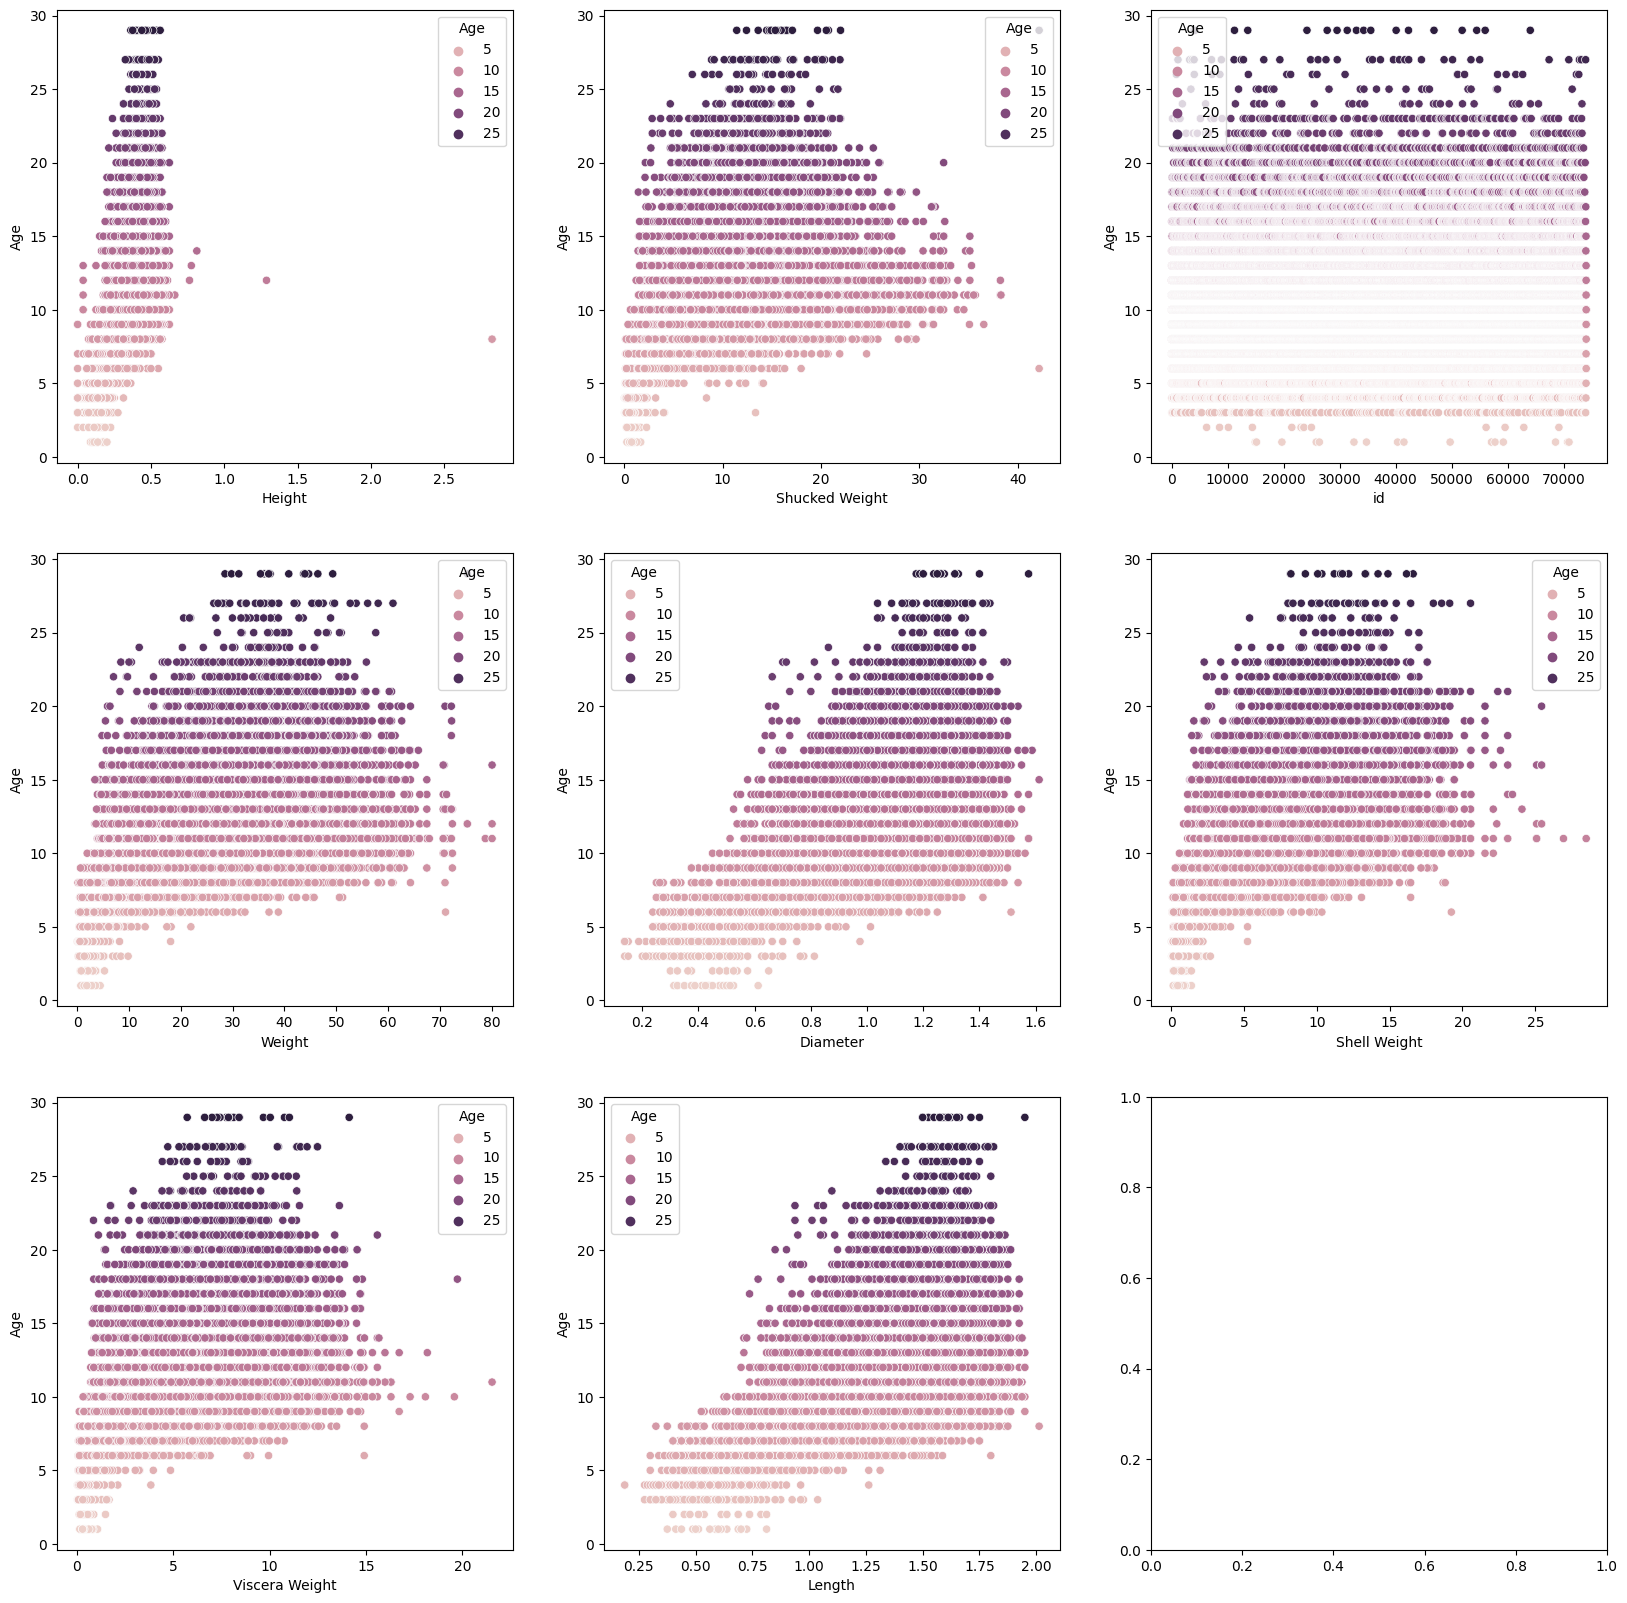

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for var, subplot in zip(numerical_features, ax.flatten()):
    sns.scatterplot(x=var, y='Age',  data=train_df, ax=subplot, hue = 'Age' )

In [11]:
y = train_df['Age']

In [12]:
# determine the mutual information for numerical features
from sklearn.feature_selection import mutual_info_regression

mutual_df = train_df[numerical_features]
mutual_info = mutual_info_regression(mutual_df, y, random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['MI-score']).style.background_gradient(cmap='cool')

,MI-score
Shell Weight,0.567039
Weight,0.509694
Height,0.487407
Diameter,0.486634
Length,0.484408
Viscera Weight,0.482912
Shucked Weight,0.457178
id,0.000000


In [13]:
# categorical feature must be encode to get mutual information

mutual_df_categorical = train_df[categorical_features]
for colname in mutual_df_categorical:
    mutual_df_categorical[colname], _ = mutual_df_categorical[colname].factorize()

mutual_info = mutual_info_regression(mutual_df_categorical, y, random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df_categorical.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Categorical_Feature_MI"] ).style.background_gradient("cool")

,Categorical_Feature_MI
Sex,0.245400


In [14]:
train_df ["volume"] = train_df["Height"] * train_df["Diameter"] * train_df["Length"]
train_df ["dim1"] = train_df["Height"] * train_df["Diameter"] 
train_df ["dim2"] = train_df["Height"] * train_df["Length"] 
train_df ["dim3"] = train_df["Diameter"] * train_df["Length"]
train_df ["total_weight"] = train_df["Shell Weight"] + train_df["Viscera Weight"] + train_df["Shucked Weight"]
train_df ["weight_volume_ratio"] = train_df["Weight"] / (train_df["Diameter"] + 1e-8 )
train_df ["shell_to_total_weight"] = train_df["Shell Weight"] / train_df["Weight"]
train_df ["viscera_to_total_weight"] = train_df["Viscera Weight"] / train_df["Weight"]
train_df ["shucked_to_total_weight"] = train_df["Shucked Weight"] / train_df["Weight"]




new_features = ["volume", 'dim1', 'dim2', 'dim3', 'total_weight', 'weight_volume_ratio', 'shell_to_total_weight','viscera_to_total_weight','shucked_to_total_weight']

In [36]:
test_df ["volume"] = test_df["Height"] * test_df["Diameter"] * test_df["Length"]
test_df ["dim1"] = test_df["Height"] * test_df["Diameter"]
test_df ["dim2"] = test_df["Height"] * test_df["Length"]
test_df ["dim3"] = test_df["Diameter"] * test_df["Length"]
test_df ["total_weight"] = test_df["Shell Weight"] + test_df["Viscera Weight"] + test_df["Shucked Weight"]
test_df ["weight_volume_ratio"] = test_df["Weight"] / (test_df["Diameter"] + 1e-8 )
test_df ["shell_to_total_weight"] = test_df["Shell Weight"] / test_df["Weight"]
test_df ["viscera_to_total_weight"] = test_df["Viscera Weight"] / test_df["Weight"]
test_df ["shucked_to_total_weight"] = test_df["Shucked Weight"] / test_df["Weight"]


In [15]:
mutual_df = train_df[new_features]

mutual_info = mutual_info_regression(mutual_df, y, random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["New_Feature_MI"] ).style.background_gradient("cool")

,New_Feature_MI
volume,0.515143
dim2,0.514823
dim1,0.514704
weight_volume_ratio,0.498733
dim3,0.495925
total_weight,0.484941
shucked_to_total_weight,0.213405
shell_to_total_weight,0.201201
viscera_to_total_weight,0.140993


In [16]:
train_df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,volume,dim1,dim2,dim3,total_weight,weight_volume_ratio,shell_to_total_weight,viscera_to_total_weight,shucked_to_total_weight
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,0.671953,0.440625,0.571875,1.791875,27.725811,24.658033,0.288160,0.229452,0.439335
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,0.249563,0.226875,0.302500,0.907500,10.248344,12.628413,0.326531,0.223129,0.434014
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,0.578848,0.417188,0.520312,1.543594,23.558435,22.271877,0.268879,0.224256,0.457666
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,1.200625,0.706250,0.850000,2.401250,46.343665,35.865880,0.296027,0.216970,0.401791
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,0.427148,0.341719,0.421875,1.265625,22.438629,23.001594,0.255630,0.193548,0.514303


In [17]:
X = train_df.drop(columns='Age')
y = train_df['Age']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59240, 18), (14811, 18), (59240,), (14811,))

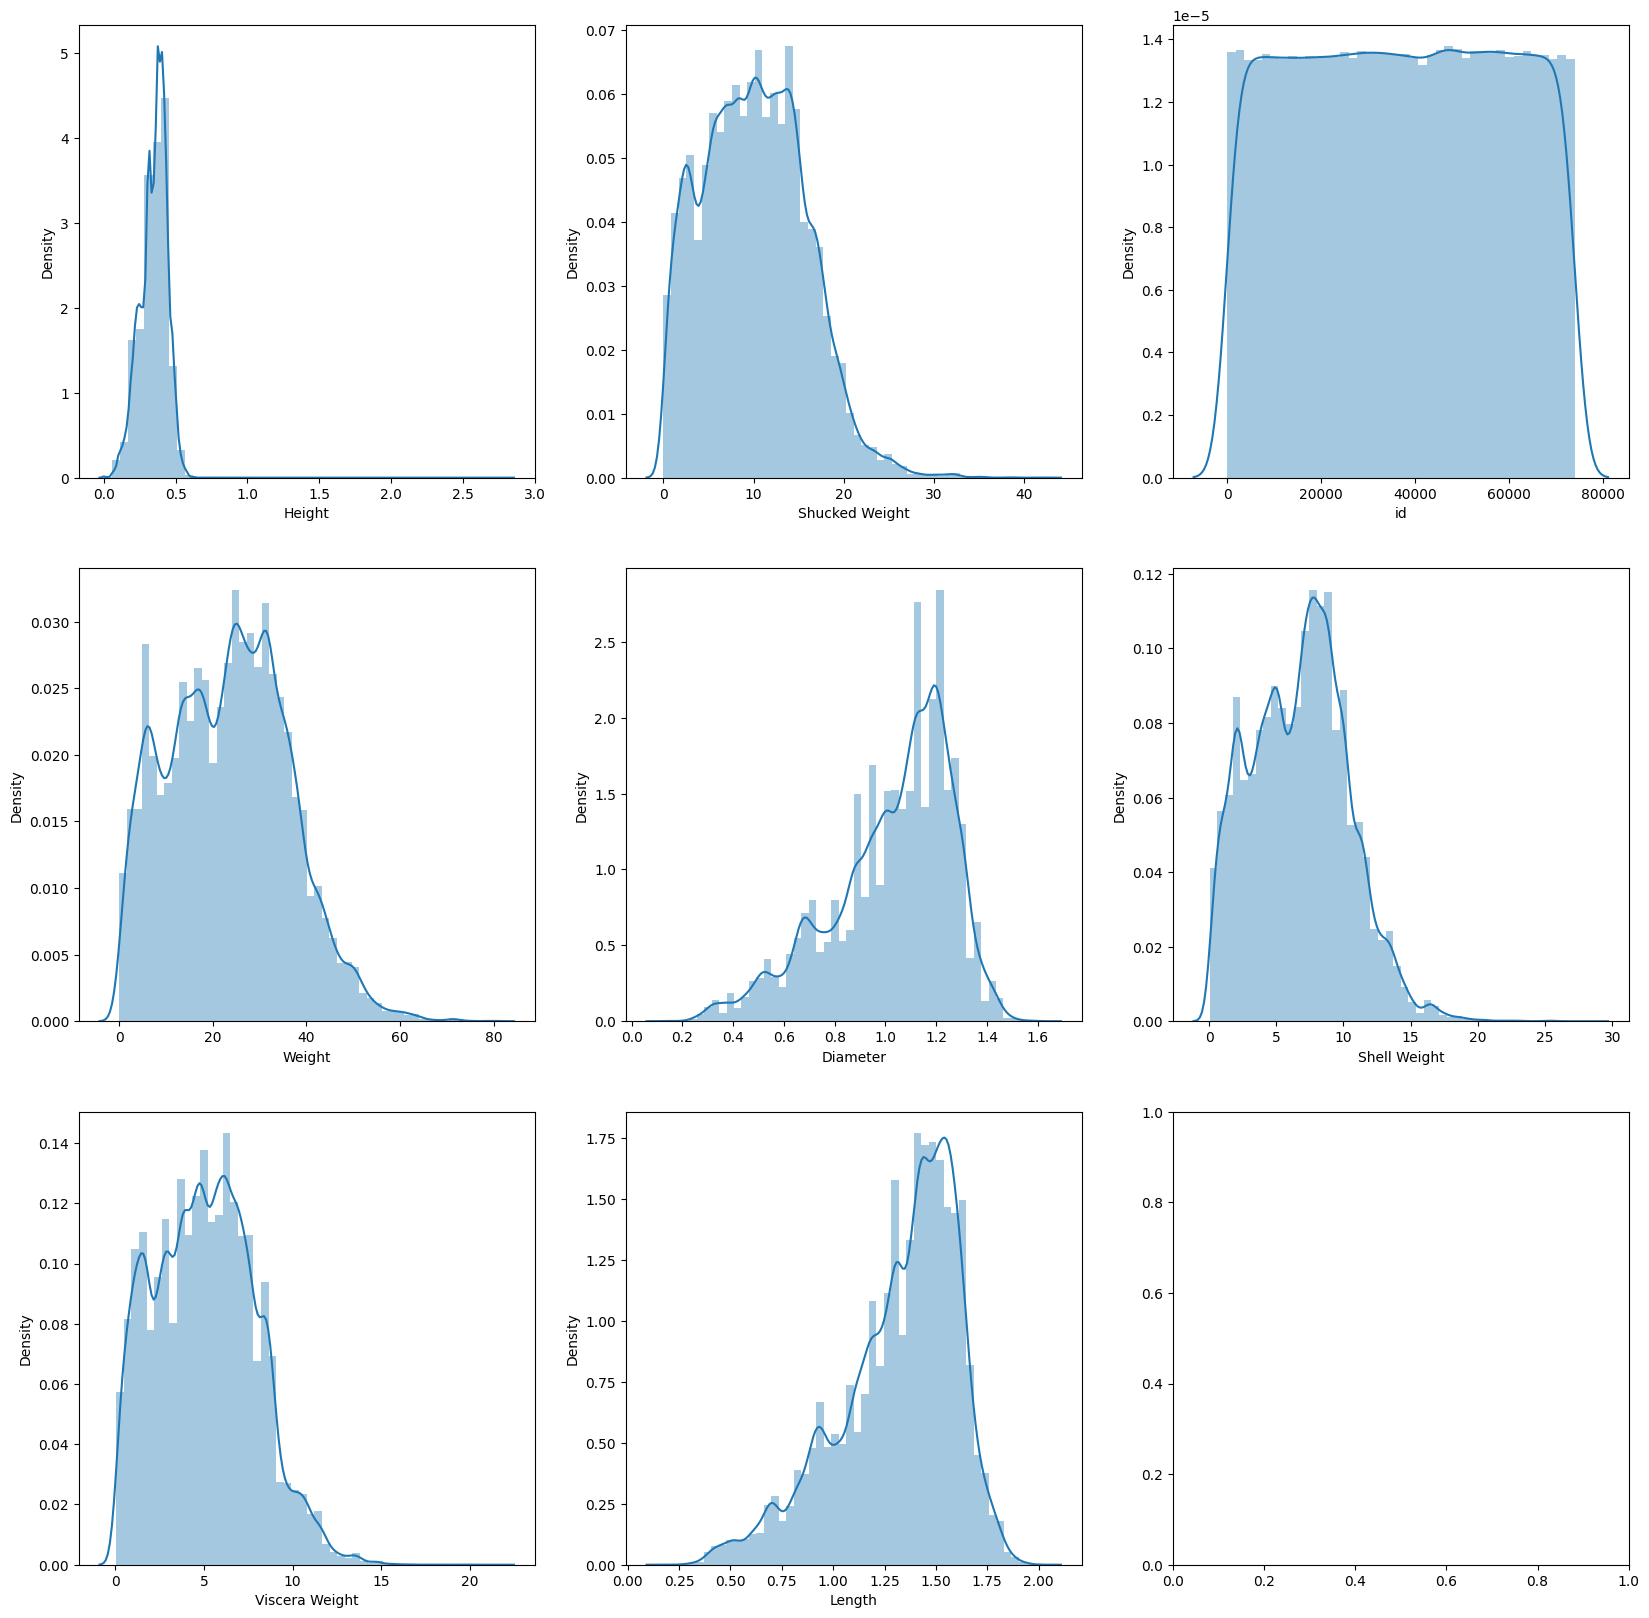

In [18]:
# check skewed plot
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for var, subplot in zip(numerical_features, ax.flatten()):
    sns.distplot(X_train[var], ax=subplot)

In [19]:
X_train.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,volume,dim1,dim2,dim3,total_weight,weight_volume_ratio,shell_to_total_weight,viscera_to_total_weight,shucked_to_total_weight
67473,67473,I,1.1625,0.9500,0.2875,15.733973,7.314171,2.934173,4.649318,0.317508,0.273125,0.334219,1.104375,14.897662,16.562076,0.295495,0.186486,0.464865
22403,22403,F,1.1750,0.9500,0.3250,14.415721,6.548735,3.288542,4.110678,0.362781,0.308750,0.381875,1.116250,13.947954,15.174443,0.285152,0.228122,0.454277
19562,19562,M,1.5750,1.2625,0.4125,35.507749,17.860185,6.973977,8.193005,0.820230,0.520781,0.649687,1.988437,33.027168,28.124949,0.230739,0.196407,0.502994
32440,32440,M,1.7750,1.3875,0.5625,60.667930,35.309302,10.560189,12.303683,1.385332,0.780469,0.998437,2.462812,58.173174,43.724634,0.202804,0.174065,0.582009
37423,37423,I,0.6250,0.4750,0.1500,2.310484,0.978058,0.467767,0.566990,0.044531,0.071250,0.093750,0.296875,2.012815,4.864177,0.245399,0.202454,0.423313


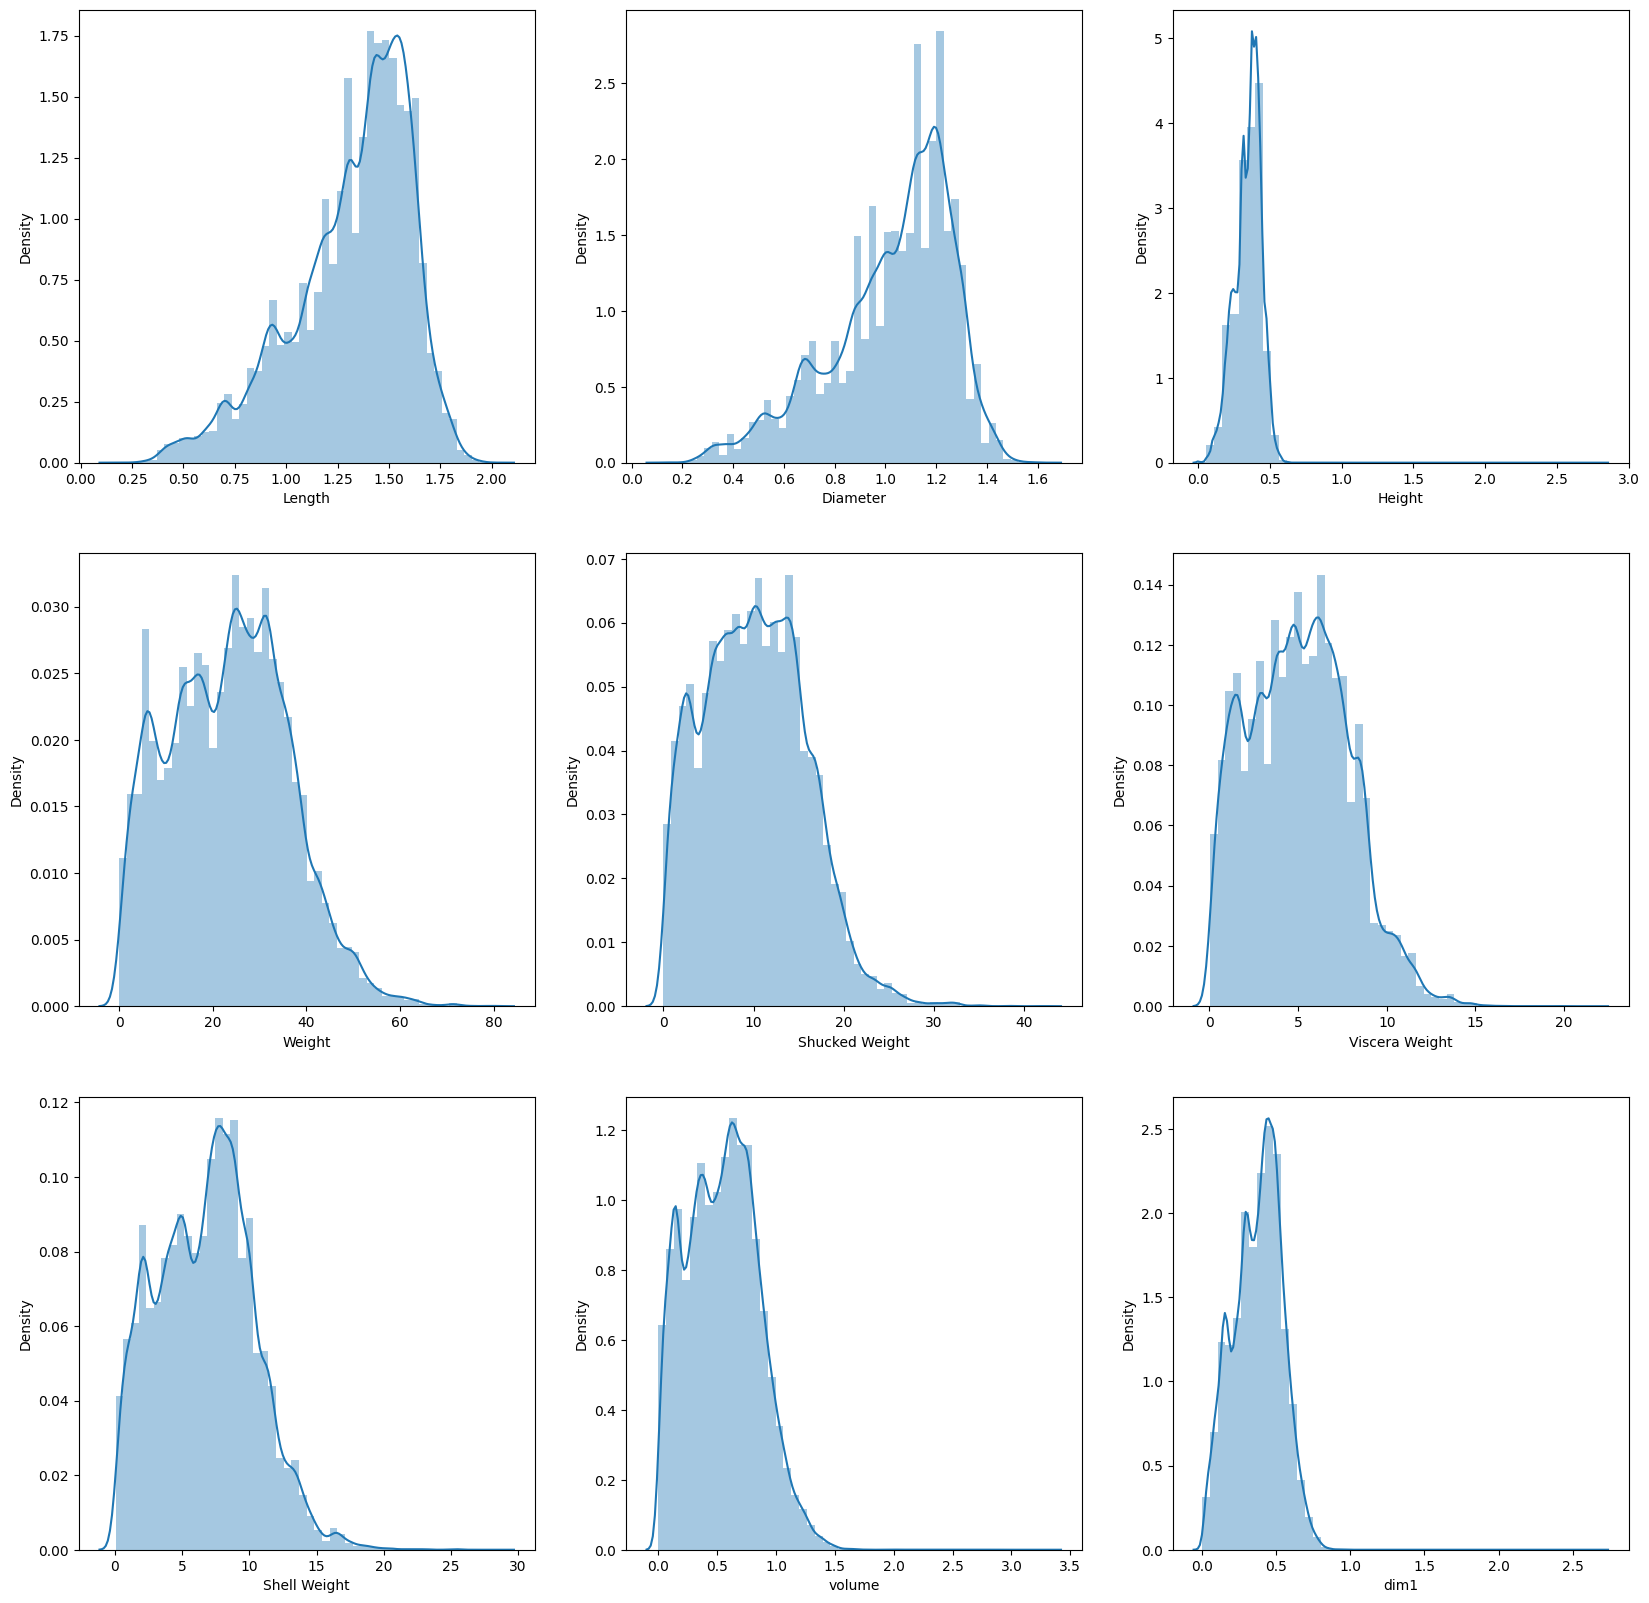

In [20]:
scaledColumn = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
                'Viscera Weight', 'Shell Weight', 'volume', 'dim1', 'dim2',
                'dim3', 'total_weight', 'weight_volume_ratio', 'shell_to_total_weight',
                'viscera_to_total_weight', 'shucked_to_total_weight']


# plot 
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for var, subplot in zip(scaledColumn, ax.flatten()):
    sns.distplot(X_train[var], ax=subplot)

In [23]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [27]:
X_train

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,volume,dim1,dim2,dim3,total_weight,weight_volume_ratio,shell_to_total_weight,viscera_to_total_weight,shucked_to_total_weight
67473,67473,I,1.1625,0.9500,0.2875,15.733973,7.314171,2.934173,4.649318,0.317508,0.273125,0.334219,1.104375,14.897662,16.562076,0.295495,0.186486,0.464865
22403,22403,F,1.1750,0.9500,0.3250,14.415721,6.548735,3.288542,4.110678,0.362781,0.308750,0.381875,1.116250,13.947954,15.174443,0.285152,0.228122,0.454277
19562,19562,M,1.5750,1.2625,0.4125,35.507749,17.860185,6.973977,8.193005,0.820230,0.520781,0.649687,1.988437,33.027168,28.124949,0.230739,0.196407,0.502994
32440,32440,M,1.7750,1.3875,0.5625,60.667930,35.309302,10.560189,12.303683,1.385332,0.780469,0.998437,2.462812,58.173174,43.724634,0.202804,0.174065,0.582009
37423,37423,I,0.6250,0.4750,0.1500,2.310484,0.978058,0.467767,0.566990,0.044531,0.071250,0.093750,0.296875,2.012815,4.864177,0.245399,0.202454,0.423313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20609,20609,F,1.6375,1.3250,0.4375,35.819593,14.132226,9.539607,8.930093,0.949238,0.579688,0.716406,2.169687,32.601925,27.033655,0.249307,0.266324,0.394539
21440,21440,I,1.1375,0.9000,0.2875,12.785625,4.706017,2.551455,3.005047,0.294328,0.258750,0.327031,1.023750,10.262519,14.206249,0.235033,0.199557,0.368071
73349,73349,I,0.5250,0.3750,0.1125,1.346601,0.538640,0.311845,0.368544,0.022148,0.042188,0.059063,0.196875,1.219028,3.590937,0.273684,0.231579,0.400000
50057,50057,M,0.9625,0.7750,0.2500,8.065433,3.019222,2.126212,2.834950,0.186484,0.193750,0.240625,0.745938,7.980384,10.407010,0.351494,0.263620,0.374341


In [31]:
ColumnTransformer = ColumnTransformer([
    ('numeric', MinMaxScaler(), scaledColumn),
    ('categoric', OneHotEncoder(), ['Sex'])
])

pipeline = Pipeline ([
    ('prep', ColumnTransformer),
    ('algo', XGBRegressor(n_jobs=-1, random_state=1))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.793214861099482, 'algo__gamma': 6, 'algo__learning_rate': 0.04052815719896151, 'algo__max_depth': 6, 'algo__n_estimators': 178, 'algo__reg_alpha': 0.48903309119411625, 'algo__reg_lambda': 1.3052357893542954, 'algo__subsample': 0.5563308494021976}
0.6263128960108111 0.5841734178783996 0.5892345631017282


In [40]:
def submit(model, filename='submission_3.csv'):
    test_df['Age'] = model.predict(test_df)
    test_df['Age'] = test_df['Age'].round(0).astype(int)
    # sisakan kolom id dan Age saja
    test_df[['id', 'Age']].to_csv(filename, index=False)

In [41]:
submit(model, 'submission_3.csv')